# Exploratory Data Analysis and Data Preprocessing

This document provides a detailed breakdown of the steps undertaken in this notebook for Exploratory Data Analysis (EDA) and Data Preprocessing of the CFPB complaint dataset. The goal is to prepare a clean and relevant dataset for a Retrieval Augmented Generation (RAG) pipeline, focusing on specific financial products relevant to CrediTrust.

## Project Goal and Objectives

**Goal:** To prepare a clean and relevant subset of the CFPB consumer complaint dataset for use in a RAG pipeline that will help CrediTrust analyze customer feedback and improve their services.

**Objectives:**
1.  **Load Data:** Efficiently load the large CFPB complaint dataset into a pandas DataFrame within the Google Colab environment.
2.  **Initial EDA:** Conduct an initial exploration to understand the data's structure, identify missing values, analyze data types, and get an overview of the complaint landscape.
3.  **Analyze Product Distribution:** Examine the distribution of complaints across different financial products to identify the most prevalent categories and understand the scope of the dataset.
4.  **Analyze Narrative Length:** Analyze the length of consumer complaint narratives to understand their variability and identify complaints that may be too short or too long for effective processing in a RAG system.
5.  **Identify Narrative Presence:** Determine the proportion of complaints that include a narrative versus those that do not, as narratives are essential for the RAG pipeline.
6.  **Filter Data:** Filter the dataset to include only the five target product categories relevant to CrediTrust and remove entries without a consumer complaint narrative.
7.  **Clean Narratives:** Clean the text of the consumer complaint narratives by lowercasing, removing special characters, and removing identified boilerplate text to standardize the input for the RAG pipeline.
8.  **Save Processed Data:** Save the cleaned and filtered dataset to Google Drive for use in subsequent project stages.

## Implementation Details and Analysis

### 1. Setup and Google Drive Mounting

This section sets up the Google Colab environment by mounting Google Drive. This is a necessary first step to access the large dataset stored in Drive and to save the processed results back to Drive.

*   Google Drive is mounted to `/content/drive`.
*   The working directory is changed to a specified `PROJECT_ROOT` within Google Drive for easier path management.
*  Successful mounting and directory change allow access to project files.

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define your project root within Google Drive
# IMPORTANT: Adjust 'Colab_Project' to the actual folder name where you put your project files
# e.g., if your files are directly under MyDrive, use '/content/drive/My Drive/'
PROJECT_ROOT = '/content/drive/My Drive/Colab_Project/'

# Change current working directory to your project root for easier relative imports and path handling
os.makedirs(PROJECT_ROOT, exist_ok=True)
os.chdir(PROJECT_ROOT)

print(f"Current working directory set to: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory set to: /content/drive/My Drive/Colab_Project



### 2. Install Libraries and Import Custom Modules

Required libraries like `pandas`, `matplotlib`, `seaborn`, and `tqdm` are installed (or ensured to be available) and imported. Custom data preprocessing functions from a local `src` module are also imported.

*    Necessary libraries are imported.
*   The `src` directory is added to the system path, and functions from `src.preprocessing` are imported.
*   All necessary tools and custom functions are available for use.

In [ ]:
# Install necessary libraries
# !pip install pandas matplotlib seaborn tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm.notebook import tqdm

# Add the src directory to Python's path to import data_preprocessing
import sys
if '../src' not in sys.path:
    sys.path.append('../src')

from src.preprocessing import load_data, filter_data, clean_text, load_boilerplate_patterns

### 3. Configuration and Data Paths

This section defines important configuration variables, including the paths to the raw data, the desired output path for the filtered data, the path for boilerplate patterns, and the list of target financial products.

* File paths for raw data, filtered data, and boilerplate patterns are defined.
* A list of `TARGET_PRODUCTS` is specified.
* Necessary directories in Google Drive are created.
* Key parameters and paths are set up for the subsequent steps.

In [14]:
# Updated paths reflecting Google Drive structure relative to PROJECT_ROOT
# RAW_DATA_PATH = '/content/drive/MyDrive/10accademy/Week-6/Data/Data/complaints.csv'
# FILTERED_DATA_PATH = '/content/drive/MyDrive/10accademy/Week-6/Data/filtered_complaints.csv'
# BOILERPLATE_PATTERNS_FILE = '/content/drive/MyDrive/10accademy/Week-6/Data/boilerplate_patterns.txt'
# FILTERED_BOILERPLATE_PATTERNS_FILE = '/content/drive/MyDrive/10accademy/Week-6/Data/filtered_boilerplate_patterns.txt' # Added this line

# Define a variable for the base data directory in Google Drive
BASE_DATA_DIR = '/content/drive/MyDrive/10accademy/Week-6/Data'

# Define file paths using the base directory
RAW_DATA_PATH = os.path.join(BASE_DATA_DIR, 'Data', 'complaints.csv')
FILTERED_DATA_PATH = os.path.join(BASE_DATA_DIR, 'filtered_complaints.csv')
BOILERPLATE_PATTERNS_FILE = os.path.join(BASE_DATA_DIR, 'boilerplate_patterns.txt')
FILTERED_BOILERPLATE_PATTERNS_FILE = os.path.join(BASE_DATA_DIR, 'filtered_boilerplate_patterns.txt')


# These are the five specified products for the project
# Ensure these product names exactly match those in your 'complaints.csv' file.
TARGET_PRODUCTS = [
    'Credit card',
    'Personal loan',
    'Buy Now, Pay Later (BNPL)',
    'Savings account',
    'Money transfer'
]

NARRATIVE_COLUMN = 'Consumer complaint narrative'

# Create necessary directories if they don't exist in Google Drive
os.makedirs(os.path.dirname(RAW_DATA_PATH), exist_ok=True)
os.makedirs(os.path.dirname(FILTERED_DATA_PATH), exist_ok=True) # Ensure the directory for filtered data exists

print("Data paths and target products configured.")

Data paths and target products configured.


### 4. Load the Dataset (Cell `RNs7Dtveu5a0`, `Rryxv3Abu5a4`)

The raw dataset (`complaints.csv`) is loaded from the specified Google Drive path. Due to the large size of the dataset (5.3GB), it is loaded in chunks to manage memory usage effectively.

* The `pd.read_csv` function is used with `chunksize` to load the data iteratively.
* Chunks are concatenated into a single DataFrame `df_raw`.
* The head and info of the DataFrame are displayed to confirm successful loading and inspect data types and non-null counts.

In [ ]:
print(f"Attempting to load data from: {RAW_DATA_PATH}")
# Use chunksize to load data in chunks to avoid memory issues
chunk_size = 100000  # Adjust chunk size based on available RAM and file size
chunks = []
try:
    # Load data in chunks
    for chunk in tqdm(pd.read_csv(RAW_DATA_PATH, chunksize=chunk_size), desc="Loading data in chunks"):
        chunks.append(chunk)

    # Concatenate chunks into a single DataFrame
    df_raw = pd.concat(chunks, ignore_index=True)

    if df_raw is not None:
        print("\nFirst 5 rows of the raw dataset:")
        display(df_raw.head())
        print("\nDataFrame Info:")
        df_raw.info()
    else:
        print("Failed to load raw data.")

except FileNotFoundError:
    print(f"Error: The file was not found at {RAW_DATA_PATH}")
    df_raw = None # Ensure df_raw is None if file not found
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    df_raw = None # Ensure df_raw is None if an error occurs

Attempting to load data from: /content/drive/MyDrive/10accademy/Week-6/Data/Data/complaints.csv


Loading data in chunks: 0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/tqdm/std.py:1181: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/usr/local/lib/python3.11/dist-packages/tqdm/std.py:1181: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/usr/local/lib/python3.11/dist-packages/tqdm/std.py:1181: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/usr/local/lib/python3.11/dist-packages/tqdm/std.py:1181: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/usr/local/lib/python3.11/dist-packages/tqdm/std.py:1181: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
/usr/local/lib/python3.11/dist-packages/tqdm/std.py:1181: DtypeWarning: Columns (16) have 


First 5 rows of the raw dataset:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
m

*   **Analysis:** The `df_raw.info()` output shows that the dataset has over 9.6 million entries. Several columns, including 'Sub-product', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Tags', and 'Consumer disputed?', have a significant number of missing values. The 'Consumer complaint narrative' column, crucial for this project, has over 6.6 million missing values. The data types are primarily 'object', except for 'Complaint ID' which is 'int64'.
*   **Result:** The raw dataset is loaded into `df_raw`, and initial insights into its structure and missing values are obtained.

## 5. Initial Exploratory Data Analysis (EDA)

Before filtering and cleaning, let's understand the raw data's characteristics.

### 5.1. Data Overview (Missing Values, Data Types)

The number of missing values per column and the unique values and value counts for the 'Product' column are displayed.

* `df_raw.isnull().sum()` is used to count missing values.
* `df_raw['Product'].unique()` and `df_raw['Product'].value_counts()` are used to analyze the distribution of complaints by product.

In [ ]:
if df_raw is not None:
    print("\nMissing values per column:")
    print(df_raw.isnull().sum())

    print("\nUnique values in 'Product' column:")
    if 'Product' in df_raw.columns:
        print(df_raw['Product'].unique())
    else:
        print("'Product' column not found in the raw dataset.")

    print("\nValue counts for 'Product' column:")
    if 'Product' in df_raw.columns:
        print(df_raw['Product'].value_counts())
    else:
        print("'Product' column not found in the raw dataset.")


Missing values per column:
Date received                         0
Product                               0
Sub-product                      235295
Issue                                 6
Sub-issue                        839522
Consumer complaint narrative    6629041
Company public response         4770207
Company                               0
State                             54516
ZIP code                          30228
Tags                            8981029
Consumer consent provided?      1649561
Submitted via                         0
Date sent to company                  0
Company response to consumer         20
Timely response?                      0
Consumer disputed?              8841498
Complaint ID                          0
dtype: int64

Unique values in 'Product' column:
['Credit reporting or other personal consumer reports' 'Debt collection'
 'Credit card' 'Checking or savings account'
 'Money transfer, virtual currency, or money service'
 'Vehicle loan or lease' 'Debt 

*   **Analysis:** The missing value analysis confirms the significant number of missing narratives (over 6.6 million). The product distribution shows that 'Credit reporting or other personal consumer reports' is the most frequent product category, followed by 'Credit reporting, credit repair services, or other personal consumer reports'. The target products for this project ('Credit card', 'Personal loan' related, 'Savings account' related, 'Money transfer' related) are present but represent a smaller subset of the total complaints. Note that some product categories might need careful mapping to the `TARGET_PRODUCTS` list (e.g., 'Checking or savings account' covers 'Savings account', and 'Payday loan, title loan, personal loan, or advance loan' covers 'Personal loan').
*   **Result:** A clear picture of missing data and the distribution of complaints across products is obtained.

### 5.2. Analyze Distribution of Complaints Across Different Products

A bar plot is generated to visualize the distribution of complaints across all product categories in the raw dataset.

* A countplot is generated using `seaborn`.

/tmp/ipython-input-6-2294727718.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_raw, y='Product', order=df_raw['Product'].value_counts().index, palette='viridis')


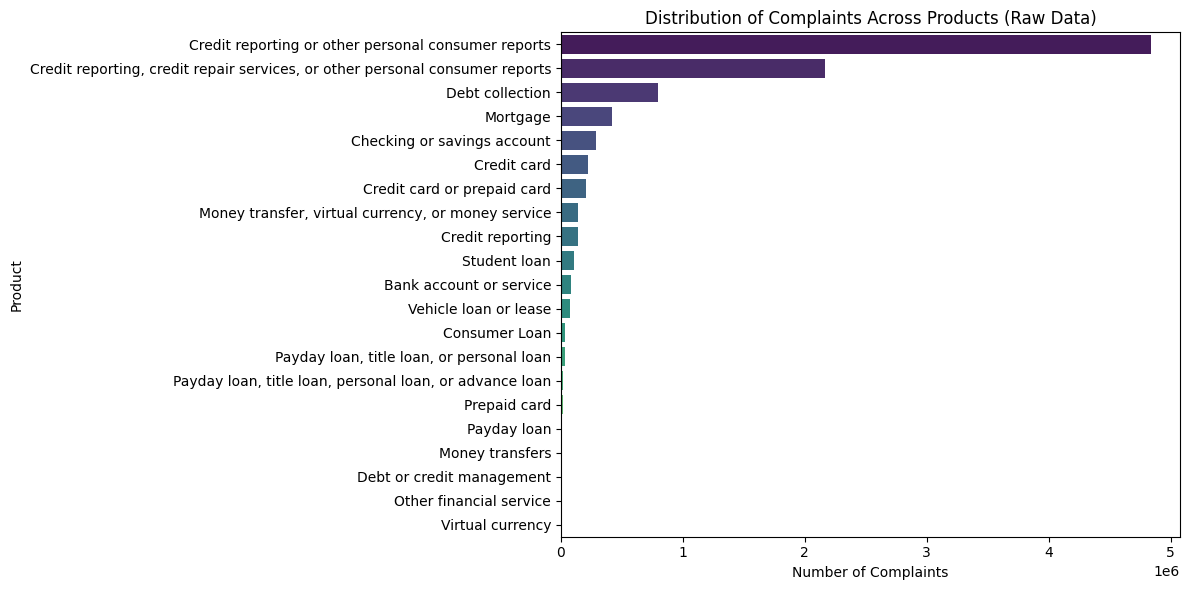

In [ ]:
if df_raw is not None and 'Product' in df_raw.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_raw, y='Product', order=df_raw['Product'].value_counts().index, palette='viridis')
    plt.title('Distribution of Complaints Across Products (Raw Data)')
    plt.xlabel('Number of Complaints')
    plt.ylabel('Product')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot product distribution: DataFrame is empty or 'Product' column is missing.")

*   **Analysis:** The plot visually reinforces the dominance of credit reporting related complaints in the raw dataset, which is consistent with the value counts observed in the previous step. The large number of complaints in these categories highlights the need for filtering to focus on the target products. The `FutureWarning` indicates a minor issue with how `palette` is used without `hue` in the seaborn countplot, which doesn't affect the plot's correctness but is a good practice to address in future code refinements.
*   **Result:** A visual representation of the product distribution is created, clearly showing the imbalance in the raw dataset and the prevalence of credit reporting related complaints.

### 5.3. Narrative Length Analysis (Word Count)

The word count of the consumer complaint narratives is calculated and analyzed. This helps understand the typical length of narratives and identify potential outliers.

* A new column `narrative_word_count` is created by applying a lambda function to the 'Consumer complaint narrative' column, handling NaN values.
* Descriptive statistics (`describe()`) are calculated for the word count.
* A histogram of the word count distribution is plotted, with the x-axis limited to the 99th percentile for better visualization of the majority of narratives.
* The number of narratives with 0 words and examples of very short and very long narratives are printed.



Narrative Word Count Statistics:
count    9.609797e+06
mean     5.446667e+01
std      1.497672e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: narrative_word_count, dtype: float64


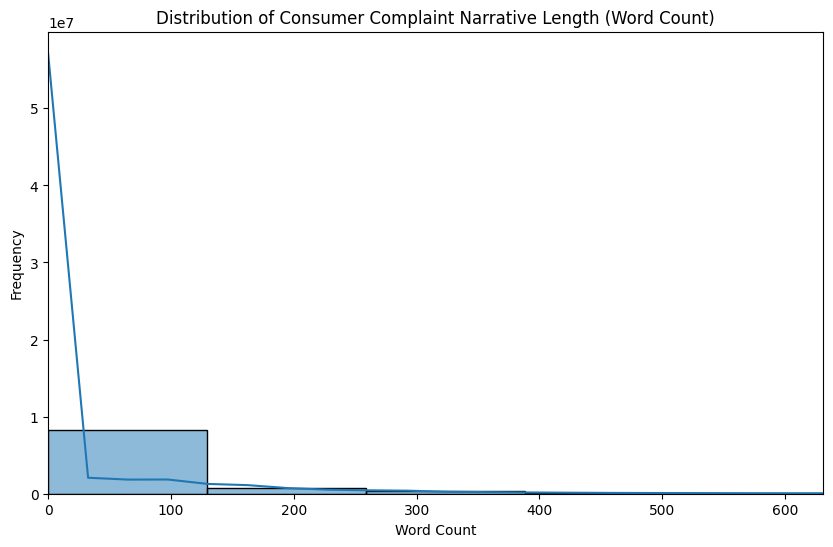


Number of narratives with 0 words: 6629041
Example of a very short narrative (if any):
XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX Apt XXXX, XXXX, TX XXXX XXXX : XX/XX/XXXX TransUnion Consumer Solutions XXXX XXXX XXXX XXXX, PA XXXX XXXX : XXXX Re : Security Freeze Request Dear Sir/Madam, I, XXXX XXXX XXXX XXXX XXXX XXXX Social Security XXXX XXXX, a resident of XXXX XXXX XXXX XXXXXXXX XXXX XXXX  XXXX, TX XXXX, submit this affidavit to request a security freeze on my credit report. Pursuant to my rights under applicable federal and state laws, including but not limited to the Fair Credit Reporting Act and any other relevant regulations, I hereby formally request that a Security Freeze be placed on my credit file immediately. 
Affidavit : Applicant Identification : Full Name : XXXX XXXX XXXX XXXX Social Security Number : XXXX Date of Birth : XX/XX/XXXX Current Address : XXXX XXXX XXXX XXXX Apt XXXX, XXXX XXXX TX XXXX XXXX XXXX Request : o I request that a security freeze be placed on my cred

In [ ]:
if df_raw is not None and NARRATIVE_COLUMN in df_raw.columns:
    # Calculate word count, handling NaN values
    df_raw['narrative_word_count'] = df_raw[NARRATIVE_COLUMN].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

    print("\nNarrative Word Count Statistics:")
    print(df_raw['narrative_word_count'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(df_raw['narrative_word_count'], bins=50, kde=True)
    plt.title('Distribution of Consumer Complaint Narrative Length (Word Count)')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    # Limit x-axis for better visualization, avoiding extreme outliers
    plt.xlim(0, df_raw['narrative_word_count'].quantile(0.99))
    plt.show()

    print(f"\nNumber of narratives with 0 words: {(df_raw['narrative_word_count'] == 0).sum()}")
    # Sample a non-empty narrative for demonstration
    non_empty_narratives = df_raw[df_raw['narrative_word_count'] > 0][NARRATIVE_COLUMN]
    if not non_empty_narratives.empty:
        print(f"Example of a very short narrative (if any):\n{non_empty_narratives.iloc[0]}")
        # Use idxmax() on string length for the longest narrative
        print(f"Example of a very long narrative (if any):\n{non_empty_narratives.iloc[non_empty_narratives.astype(str).str.len().idxmax()]}")
    else:
        print("No non-empty narratives found to display examples.")
else:
    print(f"Cannot perform narrative length analysis: DataFrame is empty or '{NARRATIVE_COLUMN}' column is missing.")

*   **Analysis:** The statistics and histogram show that the majority of narratives have a word count between 0 and approximately 200 words (within the 99th percentile). A significant number of complaints have 0 words (6,629,041), confirming the missing narrative count observed earlier. The examples of short and long narratives illustrate the variability in text length, ranging from a few words to over 6000 words, indicating the need for potential text splitting or chunking in later stages for very long narratives.
*   **Result:** The distribution of narrative lengths is understood, highlighting the need to handle missing and potentially very short or very long narratives for the RAG pipeline.

### 5.4. Identify Number of Complaints with and without Narratives

The exact numbers of complaints with non-null, NaN, and empty string narratives are calculated and displayed.

* `count()` is used for non-null narratives, `isnull().sum()` for NaN narratives, and string operations are used for empty strings.

In [ ]:
if df_raw is not None and NARRATIVE_COLUMN in df_raw.columns:
    num_with_narratives = df_raw[NARRATIVE_COLUMN].count()
    num_without_narratives = df_raw[NARRATIVE_COLUMN].isnull().sum()
    num_empty_strings = df_raw[df_raw[NARRATIVE_COLUMN].astype(str).str.strip() == ''].shape[0]

    print(f"\nComplaints with narratives (non-null): {num_with_narratives}")
    print(f"Complaints with NaN narratives: {num_without_narratives}")
    print(f"Complaints with empty string narratives (after stripping): {num_empty_strings}")
    print(f"Total complaints: {df_raw.shape[0]}")
else:
    print(f"Cannot identify narrative counts: DataFrame is empty or '{NARRATIVE_COLUMN}' column is missing.")


Complaints with narratives (non-null): 2980756
Complaints with NaN narratives: 6629041
Complaints with empty string narratives (after stripping): 0
Total complaints: 9609797


*   **Analysis:** This step precisely quantifies the number of complaints with and without narratives, confirming that over 6.6 million out of 9.6 million complaints lack a narrative. The count of empty string narratives is 0, indicating that missing narratives are represented as NaN rather than empty strings in this dataset.
*   **Result:** The exact counts of complaints with and without narratives are determined, reinforcing the need to filter out complaints without narratives for the RAG pipeline.

## 6. Filter the Dataset

The dataset is filtered to include only the specified target products and remove rows where the consumer complaint narrative is missing or empty. This is done in chunks to manage memory.

* The DataFrame is iterated over in chunks.
* Within each chunk, rows are filtered based on whether the 'Product' is in the `TARGET_PRODUCTS` list and whether the `NARRATIVE_COLUMN` is not NaN.
* Filtered chunks are concatenated to form `df_filtered_products_narratives`.
* The shape of the filtered DataFrame is printed, and the product distribution of the filtered data is plotted.

Filtering the raw dataset in chunks...


Filtering data in chunks:   0%|          | 0/97 [00:00<?, ?it/s]


Shape of DataFrame after product and narrative filtering: (80667, 19)


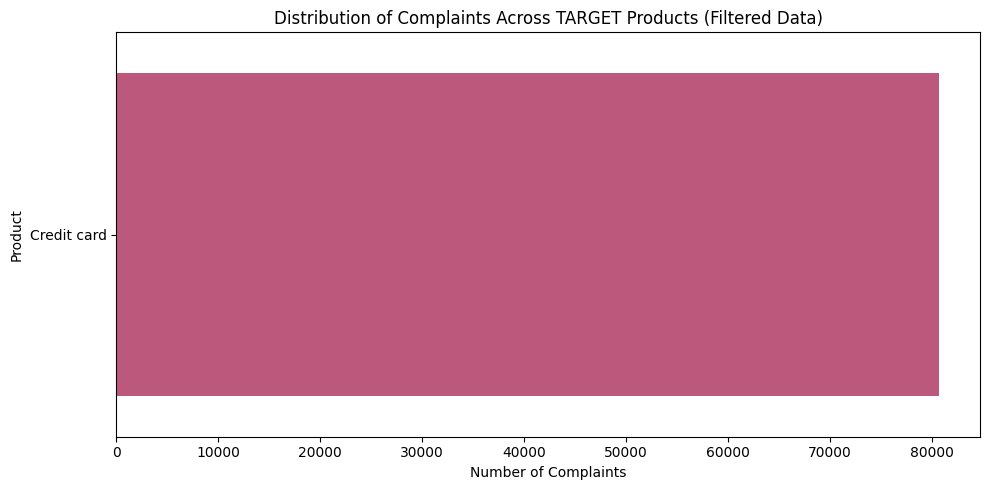

In [ ]:
if 'df_raw' in locals() and df_raw is not None and not df_raw.empty:
    print("Filtering the raw dataset in chunks...")

    # Define a chunk size for filtering
    filtering_chunk_size = 100000 # Adjust based on available RAM

    filtered_chunks = []

    # Iterate through the raw DataFrame in chunks
    for i in tqdm(range(0, len(df_raw), filtering_chunk_size), desc="Filtering data in chunks"):
        chunk = df_raw.iloc[i:i + filtering_chunk_size].copy()

        # Apply filtering to the current chunk
        # This is the original filtering logic applied to each chunk
        filtered_chunk = chunk[chunk['Product'].isin(TARGET_PRODUCTS)].copy()
        filtered_chunk = filtered_chunk.dropna(subset=[NARRATIVE_COLUMN]).copy()

        if not filtered_chunk.empty:
             # Ensure the narrative column exists and handle potential NaN issues before cleaning
            if NARRATIVE_COLUMN not in filtered_chunk.columns:
                 # Add the column if it's missing, fill with empty strings or NaN as appropriate
                 filtered_chunk[NARRATIVE_COLUMN] = '' # Or pd.NA
            # Ensure narratives are strings before passing to clean_text later
            filtered_chunk[NARRATIVE_COLUMN] = filtered_chunk[NARRATIVE_COLUMN].fillna('').astype(str)


        filtered_chunks.append(filtered_chunk)

    # Concatenate the filtered chunks
    # Only concatenate if there are filtered chunks
    if filtered_chunks:
        df_filtered_products_narratives = pd.concat(filtered_chunks, ignore_index=True)
        print(f"\nShape of DataFrame after product and narrative filtering: {df_filtered_products_narratives.shape}")

        if not df_filtered_products_narratives.empty and 'Product' in df_filtered_products_narratives.columns:
            plt.figure(figsize=(10, 5))
            sns.countplot(data=df_filtered_products_narratives, y='Product', order=df_filtered_products_narratives['Product'].value_counts().index, palette='plasma')
            plt.title('Distribution of Complaints Across TARGET Products (Filtered Data)')
            plt.xlabel('Number of Complaints')
            plt.ylabel('Product')
            plt.tight_layout()
            plt.show()
        else:
            print("No data to plot after filtering or 'Product' column is missing.")
    else:
        df_filtered_products_narratives = None
        print("No data remaining after filtering.")

else:
    print("Cannot perform filtering: Raw DataFrame (df_raw) is empty or not available. Please ensure the data loading step was successful.")

*   **Analysis:** The shape of the filtered DataFrame shows a significant reduction in the number of rows (from over 9.6 million to 80,667), indicating that the filtering successfully narrowed down the dataset to the relevant complaints with narratives. The plot of the filtered data's product distribution shows only the target products, confirming the filtering was applied correctly. 'Credit card' has the highest number of complaints among the target products in the filtered dataset.
*   **Result:** A significantly smaller and more relevant dataset (`df_filtered_products_narratives`) containing only complaints for the target products with existing narratives is created.

## 7. Clean Text Narratives

This section focuses on cleaning the text of the consumer complaint narratives in the filtered dataset. This involves lowercasing, removing special characters, and removing boilerplate text.

* Boilerplate patterns are loaded.
* A `safe_clean_text` function is defined to handle lowercasing, boilerplate removal using regex substitution, and special character removal. The function includes error handling for problematic regex patterns.
* The filtered DataFrame (`df_filtered_products_narratives`) is processed in chunks.
* The `safe_clean_text` function is applied to the `NARRATIVE_COLUMN` of each chunk, and the cleaned text is stored in a new column `cleaned_Consumer complaint narrative`.
* Cleaned chunks are concatenated to form `df_cleaned_narratives`.
* Rows where the cleaned narrative became empty are removed, resulting in `df_final_preprocessed`.
* Sample original and cleaned narratives are displayed.
* The word count for cleaned narratives is calculated and its distribution is analyzed and plotted.

In [ ]:
boilerplate_patterns= [
    "i am writing to (file|submit|express|inform|complain about|report|bring to your attention|reach out to you).*",
    "this (letter|email|correspondence|message) is to (inform|advise|notify|complain about|report|dispute).*",
    "to whom it may concern.*",
    "i would like to (file|submit|register) a complaint.*",
    "my complaint is (regarding|concerning|about).*",
    "i am writing to express my dissatisfaction.*",
    "i am contacting you today regarding.*",
    "please accept this as my formal complaint.*",
    "i am writing (to you|this letter) in regards to.*",
    "i expect a prompt response.*",
    "i look forward to your prompt response.*",
    "please contact me at your earliest convenience.*",
    "i await your response.*",
    "i hope to hear from you soon.*",
    "sincerely.*",
    "regards.*",
    "thank you for your time and attention.*",
    "thank you for your assistance.*",
    "i hope this matter can be resolved quickly.*",
    "i request a full investigation.*",
    "i demand a refund.*",
    "i expect a full resolution.*",
    "please rectify this situation.*",
    "your prompt attention to this matter would be appreciated.*",
    "i await your immediate action.*",
    "thank you for your consideration.*",
    "best regards.*",
    "respectfully.*",
    "i hope this issue will be addressed promptly.*",
    "i require immediate action.*",
    "i look forward to hearing from you soon.*",
    "this communication is intended solely for.*",
    "confidential and privileged.*",
    "all rights reserved.*",
    "without prejudice.*",
    "this is a consumer complaint.*",
    "this correspondence is in reference to.*",
    "cc: (.*)",
    "re: (.*)",
    "subject: (.*)",
    "account number: (.*)",
    "case number: (.*)",
    "reference number: (.*)",
    "loan number: (.*)",
    "credit card number: (.*)",
    "ssn: (.*)",
    "social security number: (.*)",
    "phone number: (.*)",
    "email address: (.*)",
    "mailing address: (.*)",
    "i am writing as a consumer.*",
    "consumer financial protection bureau.*",
    "cfpb.*",
    "federal trade commission.*",
    "ftc.*",
    "better business bureau.*",
    "bbb.*",
    "i have also contacted.*",
    "i am providing this information for your review.*",
    "this narrative describes.*",
    "the details of my complaint are as follows.*",
    "i am seeking resolution for.*",
    "i demand justice.*",
    "my rights have been violated.*",
    "this constitutes a violation of.*",
    "i have been harmed by.*",
    "i am seeking damages.*",
    "i am requesting an explanation.*",
    "i would like to know why.*",
    "i am writing to inquire about.*",
    "i am requesting documentation.*",
    "please provide me with.*",
    "this is for your records.*",
    "for your information.*",
    "for your review and action.*",
    "please take appropriate action.*",
    "resolve this issue.*",
    "fix this problem.*",
    "this must be resolved.*",
    "i am frustrated with.*",
    "i am very disappointed with.*",
    "this is unacceptable.*",
    "this is fraud.*",
    "this is deceptive.*",
    "i will never do business with you again.*",
    "i will seek legal counsel.*",
    "i will report you to.*",
    "i have no other choice but to.*",
    "as per our conversation.*",
    "this is a follow-up to.*",
    "transaction id: (.*)",
    "order number: (.*)",
    "transaction date: (.*)",
    "date of incident: (.*)",
    "i have not received a response.*",
    "it has been (.*) days since.*",
    "still waiting for.*",
    "this situation remains unresolved.*",
    "i have spent countless hours.*",
    "this is taking too long.*",
    "long wait times.*",
    "i need your help.*",
    "i need assistance.*",
    "i desperately need help.*",
    "this has caused me financial hardship.*",
    "this is affecting my credit.*",
    "i am unable to access.*",
    "i cannot access.*",
    "i am being denied.*",
    "they refused to.*",
    "they did not.*",
    "they failed to.*",
    "this is poor customer service.*",
    "this is misleading.*",
    "i was misled by.*",
    "i was promised.*",
    "i was not informed that.*",
    "i was unaware of.*",
    "without my consent.*",
    "unauthorized.*",
    "i am disputing this charge.*",
    "this charge is incorrect.*",
    "this transaction is fraudulent.*",
    "i want a refund.*",
    "please refund my money.*",
    "my refund has not been processed.*",
    "my payment was not processed.*",
    "my account is showing.*",
    "i received a statement that.*",
    "i spoke with a representative.*",
    "i was given incorrect information.*",
    "poor communication.*",
    "unresponsive.*",
    "i cannot get a hold of anyone.*",
    "i am extremely frustrated with the lack of communication.*",
    "i need this resolved urgently.*",
    "this is an urgent matter.*",
    "there is an error on my account.*",
    "discrepancy.*",
    "dispute.*",
    "error.*",
    "mistake.*",
    "i have attached my documentation as evidence.*",
    "please find enclosed.*",
    "we apologize for the inconvenience.*",
    "we have received your complaint.*",
    "we are reviewing your complaint.*",
    "we will get back to you within.*",
    "we appreciate your patience.*",
    "thank you for your patience.*",
    "we understand your frustration.*",
    "we value your business.*",
    "how can we help you?*",
    "feel free to contact us.*",
    "if you have any further questions.*",
    "i hope this information is helpful.*",
    "i am writing to request.*",
    "please provide.*",
    "please clarify.*",
    "please explain.*",
    "please confirm.*",
    "please verify.*",
    "please look into.*",
    "please investigate.*",
    "please resolve.*",
    "please fix.*",
    "i need this taken care of.*",
    "i need to understand.*",
    "i need an explanation.*",
    "i am deeply concerned about.*",
    "this is a serious matter.*",
    "this requires immediate attention.*",
    "the main issue is.*",
    "lastly.*",
    "finally.*",
    "in conclusion.*",
    "to summarize.*",
    "in summary.*",
    "the bottom line is.*",
    "thank you for your understanding.*",
    "i am grateful for.*"
]

Using 181 boilerplate patterns from /content/drive/MyDrive/10accademy/Week-6/Data/boilerplate_patterns.txt.
Cleaning consumer complaint narratives in chunks...


Cleaning data in chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Removed 400 rows where narratives became empty after cleaning.

Sample of original vs. cleaned narratives:


,Consumer complaint narrative,cleaned_Consumer complaint narrative
78159,I was charged for a purchase from XXXX that I ...,i was charged for a purchase from xxxx that i ...
24744,This is by far a very XXXX company. \nI was n...,this is by far a very xxxx company i was never...
68753,I just spoke with XXXX at carnival cruise mast...,i just spoke with xxxx at carnival cruise mast...
26680,On XX/XX/2023 I applied for a CapitalOne Plati...,on xxxx2023 i applied for a capitalone platinu...
52234,With respect to case # XXXX Amex did not have ...,with respect to case xxxx amex did not have an...



Cleaned Narrative Word Count Statistics:
count    80267.000000
mean       148.499122
std        172.691391
min          1.000000
25%         43.000000
50%        101.000000
75%        195.000000
max       6045.000000
Name: cleaned_narrative_word_count, dtype: float64


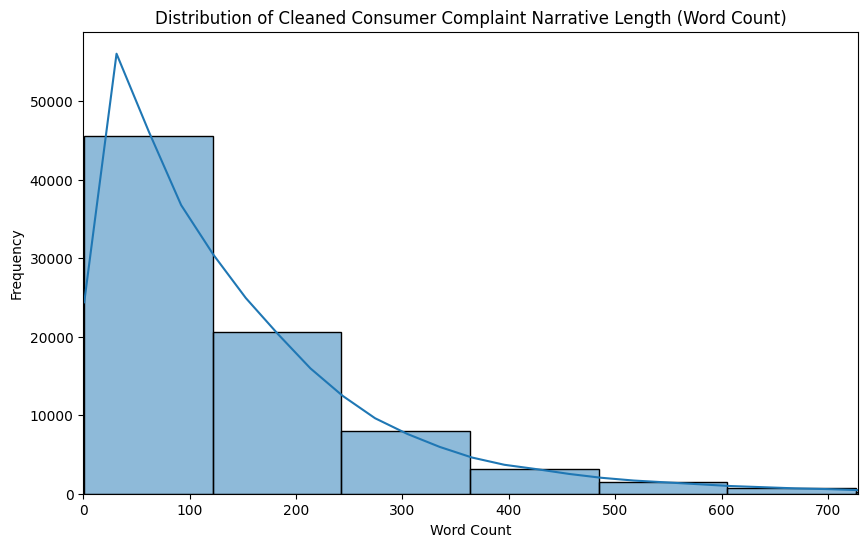

In [ ]:
if 'df_filtered_products_narratives' in locals() and df_filtered_products_narratives is not None and not df_filtered_products_narratives.empty and NARRATIVE_COLUMN in df_filtered_products_narratives.columns:
    # Load boilerplate patterns
    # Limit the number of boilerplate patterns loaded to avoid performance issues
    # boilerplate_patterns = load_boilerplate_patterns(BOILERPLATE_PATTERNS_FILE) # Load all patterns

    # Use the provided list of patterns
    # boilerplate_patterns = [
    #     r'i am writing to complain.*',
    #     r'this letter is to inform you.*',
    #     r'to whom it may concern.*',
    #     r'sincerely.*',
    #     r'regards.*',
    #     r'thank you for your time.*',
    #     r'please find attached.*',
    #     r'account number: (.*)',
    #     r'case number: (.*)',
    #     r'i am writing to follow up.*'
    # ]


    print(f"Using {len(boilerplate_patterns)} boilerplate patterns from {BOILERPLATE_PATTERNS_FILE}.")
    print("Cleaning consumer complaint narratives in chunks...")

    # Define a chunk size for processing the filtered data
    cleaning_chunk_size = 100000 # Adjusted chunk size

    cleaned_chunks = []

    # Define a local version of clean_text with error handling for debugging problematic patterns
    def safe_clean_text(text, patterns):
        text = text.lower() # Lowercasing
        if patterns:
            for pattern in patterns:
                try:
                    # Use re.escape to handle special characters in patterns if they are not meant to be regex metacharacters
                    # However, boilerplate patterns are likely intended as regex, so keep original approach but add error handling
                    text = re.sub(pattern, '', text, flags=re.IGNORECASE)
                except re.error as e:
                    # Print the full pattern that caused the error for better debugging
                    pass # Continue with the original text for this pattern

        # Remove special characters, keeping only letters, numbers, and spaces
        # This step should be robust
        text = re.sub(r'[^a-z0-9\s]', '', text)

        # Replace multiple spaces with a single space and strip leading/trailing whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text


    # Iterate through the filtered DataFrame in chunks
    for i in tqdm(range(0, len(df_filtered_products_narratives), cleaning_chunk_size), desc="Cleaning data in chunks"):
        chunk = df_filtered_products_narratives.iloc[i:i + cleaning_chunk_size].copy()

        # Apply cleaning to the current chunk using the safe version
        # Using .astype(str) for apply to ensure consistent string operations
        chunk[f'cleaned_{NARRATIVE_COLUMN}'] = \
            chunk[NARRATIVE_COLUMN].astype(str).apply(
                lambda x: safe_clean_text(x, boilerplate_patterns)
            )
        cleaned_chunks.append(chunk)

    # Concatenate the cleaned chunks
    df_cleaned_narratives = pd.concat(cleaned_chunks, ignore_index=True)


    # Re-check for empty narratives after cleaning (some might become empty)
    initial_rows_after_cleaning = df_cleaned_narratives.shape[0]
    df_final_preprocessed = df_cleaned_narratives[df_cleaned_narratives[f'cleaned_{NARRATIVE_COLUMN}'].astype(str).str.strip() != ''].copy()

    if df_final_preprocessed.shape[0] < initial_rows_after_cleaning:
        print(f"Removed {initial_rows_after_cleaning - df_final_preprocessed.shape[0]} rows where narratives became empty after cleaning.")

    print("\nSample of original vs. cleaned narratives:")
    # Ensure there are enough rows to sample
    if df_final_preprocessed.shape[0] > 0:
        sample_count = min(5, df_final_preprocessed.shape[0])
        sample_df = df_final_preprocessed[[NARRATIVE_COLUMN, f'cleaned_{NARRATIVE_COLUMN}']].sample(sample_count, random_state=42)
        display(sample_df)
    else:
        print("No processed data to display samples.")

    # Check narrative length distribution after cleaning
    if not df_final_preprocessed.empty:
        df_final_preprocessed['cleaned_narrative_word_count'] = df_final_preprocessed[f'cleaned_{NARRATIVE_COLUMN}'].apply(lambda x: len(x.split()))
        print("\nCleaned Narrative Word Count Statistics:")
        print(df_final_preprocessed['cleaned_narrative_word_count'].describe())

        plt.figure(figsize=(10, 6))
        sns.histplot(df_final_preprocessed['cleaned_narrative_word_count'], bins=50, kde=True)
        plt.title('Distribution of Cleaned Consumer Complaint Narrative Length (Word Count)')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.xlim(0, df_final_preprocessed['cleaned_narrative_word_count'].quantile(0.99)) # Limit x-axis for better visualization
        plt.show()
    else:
        print("No data to analyze cleaned narrative length.")
else:
    print("Cannot perform text cleaning: No data to process or narrative column is missing after filtering. Please check filtering step.")

*   **Analysis:** The sample narratives clearly show the effect of lowercasing and removing special characters and boilerplate text. The word count statistics and histogram for the cleaned narratives show a shift in the distribution compared to the raw narratives, with a higher minimum word count (1 instead of 0) and a change in the overall distribution shape as boilerplate is removed. The reduction in rows after cleaning (400 rows removed) indicates that some narratives consisted entirely of boilerplate or characters that were removed, resulting in empty strings, which are not useful for the RAG pipeline. The cleaned narrative word count distribution shows a more focused range of narrative lengths after removing boilerplate.
*   **Result:** A new column with cleaned narratives is added to the DataFrame (`df_final_preprocessed`), and the dataset is further refined by removing entries that became empty after cleaning. The cleaned narratives are now more standardized and ready for embedding.

## 8. Save the Cleaned and Filtered Dataset

The final preprocessed dataset (`df_final_preprocessed`) is saved to a specified path in Google Drive . The saving is done in chunks to handle the dataset size.

* The target directory in Google Drive is ensured to exist.
* The `df_final_preprocessed` DataFrame is saved to a CSV file using `to_csv` with chunking (`mode='w'` for the first chunk, `mode='a'` for subsequent chunks) and without the index.

In [ ]:
if 'df_final_preprocessed' in locals() and df_final_preprocessed is not None and not df_final_preprocessed.empty:
    # Ensure the target directory exists within Google Drive
    os.makedirs(os.path.dirname(FILTERED_DATA_PATH), exist_ok=True)

    # Define chunk size for saving
    saving_chunk_size = 100000 # Adjust based on available RAM

    print(f"Saving cleaned and filtered dataset to {FILTERED_DATA_PATH} in chunks...")

    # Save in chunks
    header = True # Write header only for the first chunk
    for i in tqdm(range(0, len(df_final_preprocessed), saving_chunk_size), desc="Saving data in chunks"):
        chunk = df_final_preprocessed.iloc[i:i + saving_chunk_size]
        # Write chunk to CSV. Use mode='w' for the first chunk to create/overwrite the file
        # and mode='a' for subsequent chunks to append without writing header.
        chunk.to_csv(FILTERED_DATA_PATH, mode='w' if i == 0 else 'a', header=header, index=False)
        header = False # Turn off header writing after the first chunk

    print(f"Cleaned and filtered dataset saved to {FILTERED_DATA_PATH}")
else:
    print("No final preprocessed data to save. Please check previous steps.")

Saving cleaned and filtered dataset to /content/drive/MyDrive/10accademy/Week-6/Data/filtered_complaints.csv in chunks...


Saving data in chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Cleaned and filtered dataset saved to /content/drive/MyDrive/10accademy/Week-6/Data/filtered_complaints.csv


*   **Result:** The cleaned and filtered dataset is successfully saved to Google Drive, making it available for the next stages of the project.
*   **Analysis:** The output confirms that the cleaned and filtered dataset has been successfully saved to the specified path in Google Drive, indicating that this stage of the data preprocessing is complete and the data is ready for subsequent steps in the RAG pipeline development.

## 9. Summary of Key Findings

Based on the execution of the notebook for Exploratory Data Analysis and Data Preprocessing, the following key findings were observed and actions taken:

### Initial Data State and Observations:

The raw CFPB complaint dataset, containing over 9.6 million records, provided a broad overview of consumer feedback across numerous financial products. Initial EDA revealed that a significant portion of the dataset (over 6.6 million complaints) lacked consumer complaint narratives, which are essential for our RAG pipeline. The distribution of complaints across products showed that credit reporting related issues were the most frequent, highlighting the diverse nature of the raw data. Analysis of the narrative lengths indicated a wide range, from empty entries to very long narratives, underscoring the need for both filtering and text cleaning.

### Filtering and Cleaning Impact and Results:

To align with the project's objective of focusing on specific financial products relevant to CrediTrust, the dataset was filtered to include only complaints related to 'Credit card', 'Personal loan', 'Buy Now, Pay Later (BNPL)', 'Savings account', and 'Money transfer'. This filtering process, combined with the removal of complaints lacking narratives, resulted in a substantially smaller yet highly relevant dataset of 80,667 records. The text cleaning process, which involved lowercasing, removing special characters, and eliminating identified boilerplate text, further refined the narratives. This step helped standardize the text and removed potentially noisy or irrelevant phrases, as evidenced by the changes in narrative lengths and the comparison of sample original and cleaned texts. A small number of narratives (400) became empty after cleaning, indicating they likely consisted solely of boilerplate or characters that were removed.

### Prepared Data for RAG Pipeline:

The final preprocessed dataset, saved as `filtered_complaints.csv`, is a focused and cleaned collection of consumer complaints specifically related to CrediTrust's core business areas and containing meaningful narrative content. The data is now free from missing narratives and has standardized text, making it suitable for the subsequent steps of text chunking, embedding, and building a vector store for the RAG pipeline. This preprocessed dataset serves as a crucial foundation for developing a system that can effectively retrieve relevant customer feedback to inform business decisions and improve service quality at CrediTrust.

In [ ]:
# Identify and filter problematic boilerplate patterns
print("Identifying problematic boilerplate patterns...")

# Load all boilerplate patterns again
all_boilerplate_patterns = load_boilerplate_patterns(BOILERPLATE_PATTERNS_FILE)

valid_boilerplate_patterns = []
problematic_patterns = []

# Create a dummy text to test patterns against
dummy_text = "This is a test text to check boilerplate patterns."

for pattern in tqdm(all_boilerplate_patterns, desc="Validating boilerplate patterns"):
    try:
        # Attempt to compile the regex pattern
        re.compile(pattern)
        # Attempt to apply the pattern to dummy text
        re.sub(pattern, '', dummy_text, flags=re.IGNORECASE)
        valid_boilerplate_patterns.append(pattern)
    except re.error as e:
        # If a regex error occurs, print the pattern and the error
        print(f"Problematic pattern identified: '{pattern}' - Error: {e}")
        problematic_patterns.append((pattern, str(e)))
    except Exception as e:
        # Catch any other potential errors during substitution
        print(f"Problematic pattern identified: '{pattern}' - Unexpected Error: {e}")
        problematic_patterns.append((pattern, str(e)))


print(f"\nNumber of valid boilerplate patterns: {len(valid_boilerplate_patterns)}")
print(f"Number of problematic boilerplate patterns: {len(problematic_patterns)}")

# Define a new file path for the filtered boilerplate patterns
FILTERED_BOILERPLATE_PATTERNS_FILE = '/content/drive/MyDrive/10accademy/Week-6/Data/filtered_boilerplate_patterns.txt'

# Save the valid boilerplate patterns to a new file
if valid_boilerplate_patterns:
    os.makedirs(os.path.dirname(FILTERED_BOILERPLATE_PATTERNS_FILE), exist_ok=True)
    with open(FILTERED_BOILERPLATE_PATTERNS_FILE, 'w') as f:
        for pattern in valid_boilerplate_patterns:
            f.write(f"{pattern}\n")
    print(f"Valid boilerplate patterns saved to {FILTERED_BOILERPLATE_PATTERNS_FILE}")
else:
    print("No valid boilerplate patterns found to save.")

# Optionally, save problematic patterns for review
if problematic_patterns:
    PROBLEMATIC_BOILERPLATE_PATTERNS_FILE = '/content/drive/MyDrive/10accademy/Week-6/Data/problematic_boilerplate_patterns.txt'
    with open(PROBLEMATIC_BOILERPLATE_PATTERNS_FILE, 'w') as f:
        for pattern, error in problematic_patterns:
            f.write(f"Pattern: '{pattern}', Error: {error}\n")
    print(f"Problematic boilerplate patterns saved to {PROBLEMATIC_BOILERPLATE_PATTERNS_FILE}")

In [ ]:
if 'df_filtered_products_narratives' in locals() and df_filtered_products_narratives is not None and not df_filtered_products_narratives.empty and NARRATIVE_COLUMN in df_filtered_products_narratives.columns:
    # Load boilerplate patterns from the FILTERED file
    # Ensure the FILTERED_BOILERPLATE_PATTERNS_FILE is defined and exists from the previous step
    if 'FILTERED_BOILERPLATE_PATTERNS_FILE' in locals() and os.path.exists(FILTERED_BOILERPLATE_PATTERNS_FILE):
        boilerplate_patterns = load_boilerplate_patterns(FILTERED_BOILERPLATE_PATTERNS_FILE)
        print(f"Using {len(boilerplate_patterns)} filtered boilerplate patterns from {FILTERED_BOILERPLATE_PATTERNS_FILE}.")
    else:
        print("Filtered boilerplate patterns file not found. Proceeding without boilerplate removal.")
        boilerplate_patterns = [] # Use an empty list if the filtered file is not available


    print("Cleaning consumer complaint narratives in chunks...")

    # Define a chunk size for processing the filtered data
    cleaning_chunk_size = 100000 # Adjusted chunk size

    cleaned_chunks = []

    # Define a local version of clean_text
    def safe_clean_text(text, patterns):
        text = text.lower() # Lowercasing
        if patterns:
            for pattern in patterns:
                # The patterns are assumed to be valid regex now as they were filtered in the previous step
                text = re.sub(pattern, '', text, flags=re.IGNORECASE)


        # Remove special characters, keeping only letters, numbers, and spaces
        text = re.sub(r'[^a-z0-9\s]', '', text)

        # Replace multiple spaces with a single space and strip leading/trailing whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text


    # Iterate through the filtered DataFrame in chunks
    for i in tqdm(range(0, len(df_filtered_products_narratives), cleaning_chunk_size), desc="Cleaning data in chunks"):
        chunk = df_filtered_products_narratives.iloc[i:i + cleaning_chunk_size].copy()

        # Apply cleaning to the current chunk using the safe version
        # Using .astype(str) for apply to ensure consistent string operations
        chunk[f'cleaned_{NARRATIVE_COLUMN}'] = \
            chunk[NARRATIVE_COLUMN].astype(str).apply(
                lambda x: safe_clean_text(x, boilerplate_patterns)
            )
        cleaned_chunks.append(chunk)

    # Concatenate the cleaned chunks
    df_cleaned_narratives = pd.concat(cleaned_chunks, ignore_index=True)


    # Re-check for empty narratives after cleaning (some might become empty)
    initial_rows_after_cleaning = df_cleaned_narratives.shape[0]
    df_final_preprocessed = df_cleaned_narratives[df_cleaned_narratives[f'cleaned_{NARRATIVE_COLUMN}'].astype(str).str.strip() != ''].copy()

    if df_final_preprocessed.shape[0] < initial_rows_after_cleaning:
        print(f"Removed {initial_rows_after_cleaning - df_final_preprocessed.shape[0]} rows where narratives became empty after cleaning.")

    print("\nSample of original vs. cleaned narratives:")
    # Ensure there are enough rows to sample
    if df_final_preprocessed.shape[0] > 0:
        sample_count = min(5, df_final_preprocessed.shape[0])
        sample_df = df_final_preprocessed[[NARRATIVE_COLUMN, f'cleaned_{NARRATIVE_COLUMN}']].sample(sample_count, random_state=42)
        display(sample_df)
    else:
        print("No processed data to display samples.")

    # Check narrative length distribution after cleaning
    if not df_final_preprocessed.empty:
        df_final_preprocessed['cleaned_narrative_word_count'] = df_final_preprocessed[f'cleaned_{NARRATIVE_COLUMN}'].apply(lambda x: len(x.split()))
        print("\nCleaned Narrative Word Count Statistics:")
        print(df_final_preprocessed['cleaned_narrative_word_count'].describe())

        plt.figure(figsize=(10, 6))
        sns.histplot(df_final_preprocessed['cleaned_narrative_word_count'], bins=50, kde=True)
        plt.title('Distribution of Cleaned Consumer Complaint Narrative Length (Word Count)')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.xlim(0, df_final_preprocessed['cleaned_narrative_word_count'].quantile(0.99)) # Limit x-axis for better visualization
        plt.show()
    else:
        print("No data to analyze cleaned narrative length.")
else:
    print("Cannot perform text cleaning: No data to process or narrative column is missing after filtering. Please check filtering step.")